# Creating BaseLine Model with GANs

In [1]:
!apt-get update
!pip install pydot
!apt install graphviz -y

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done

[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 68 not upgraded.


In [2]:
import tensorflow as tf
import numpy as np

2024-11-20 06:13:12.155966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-20 06:13:12.179153: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-20 06:13:12.185839: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 06:13:12.206511: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
!pwd

/tf/notebooks


## Building the Generator

In [4]:
from tensorflow.keras.layers import Dense,Reshape,Dropout,LeakyReLU,Flatten,BatchNormalization,Conv2D,Conv2DTranspose,Resizing,Normalization,Input,Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
import os
import itertools

In [5]:
import pickle

# Replace 'file.pkl' with the path to your pickle file
data = None
with open('images_dict.pkl', 'rb') as file:
    data = pickle.load(file)

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

In [7]:
# Set up paths to directories
object_dir = '/tf/notebooks/targets'
background_dir = '/tf/notebooks/backgrounds'
original_image_dir = '/tf/notebooks/awsaf49/coco-2017-dataset/versions/2/coco2017/train2017'
IMG_HEIGHT = 240
IMG_WIDTH = 240
BATCH_SIZE = 3
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

In [8]:
def load_and_preprocess_image(image_path):
    tf.print("Loading:", image_path)  # Works in graph mode
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.cast(img, tf.float32) / 255.0
    return img


In [9]:
object_paths = list()
background_paths = list()
original_image_paths = list()

In [10]:
for key,value in data.items():
    if len(value["targets"]) == len(value["backgrounds"]):
        original_image_path = original_image_dir+"/" + key +".jpg"
        for object_path,bg_path in zip(value["targets"],value["backgrounds"]):
            if isinstance(object_path, str) and isinstance(bg_path, str) and isinstance(original_image_path,str):
                
                object_paths.append(os.getcwd()+"/"+object_path)
                background_paths.append(os.getcwd()+"/"+bg_path)
                original_image_paths.append(original_image_path)

In [11]:
if not (len(object_paths) == len(background_paths) == len(original_image_paths)):
    raise ValueError("All directories must have the same number of images.")

In [12]:
object_dataset = tf.data.Dataset.from_tensor_slices(object_paths).map(load_and_preprocess_image)

I0000 00:00:1732083195.264572     936 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732083195.271618     936 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732083195.271679     936 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732083195.274384     936 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732083195.274464     936 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [13]:
background_dataset = tf.data.Dataset.from_tensor_slices(background_paths).map(load_and_preprocess_image)
original_image_dataset = tf.data.Dataset.from_tensor_slices(original_image_paths).map(load_and_preprocess_image)

In [14]:
dataset = tf.data.Dataset.zip(((object_dataset, background_dataset), original_image_dataset)).batch(BATCH_SIZE,drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
def build_generator():
    object_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    background_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = Concatenate()([object_input, background_input])
    x = Conv2D(64, (5, 5), strides=(2, 2), padding='same',activation=LeakyReLU(0.3))(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (5, 5), strides=(2, 2), padding='same',activation=LeakyReLU(0.3))(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same',activation="tanh")(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same',activation="tanh")(x)
    x = BatchNormalization()(x)
    output_image = Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', activation='tanh')(x)
    
    return tf.keras.Model([object_input, background_input], output_image)

In [16]:
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[IMG_HEIGHT, IMG_WIDTH, 3]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1))
    return model

In [17]:
generator = build_generator()

In [18]:
discriminator = build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
GAN = Sequential([generator, discriminator])

In [20]:
discriminator.compile(loss="binary_crossentropy",optimizer="adam")
discriminator.trainable = False

In [21]:
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [22]:
GAN.layers
image1_input = np.random.rand(1, 240, 240, 3).astype(np.float32)  # First RGB image
image2_input = np.random.rand(1, 240, 240, 3).astype(np.float32)  # Second RGB image

# Pass both inputs to build the model
GAN([image1_input, image2_input])

2024-11-20 06:13:15.912003: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
W0000 00:00:1732083195.991866     936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732083196.041540     936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732083196.050478     936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732083196.055138     936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732083196.059255     936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732083196.061503     936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732083196.072099     936 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732083196.079154     936 gpu_t

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.01333611]], dtype=float32)>

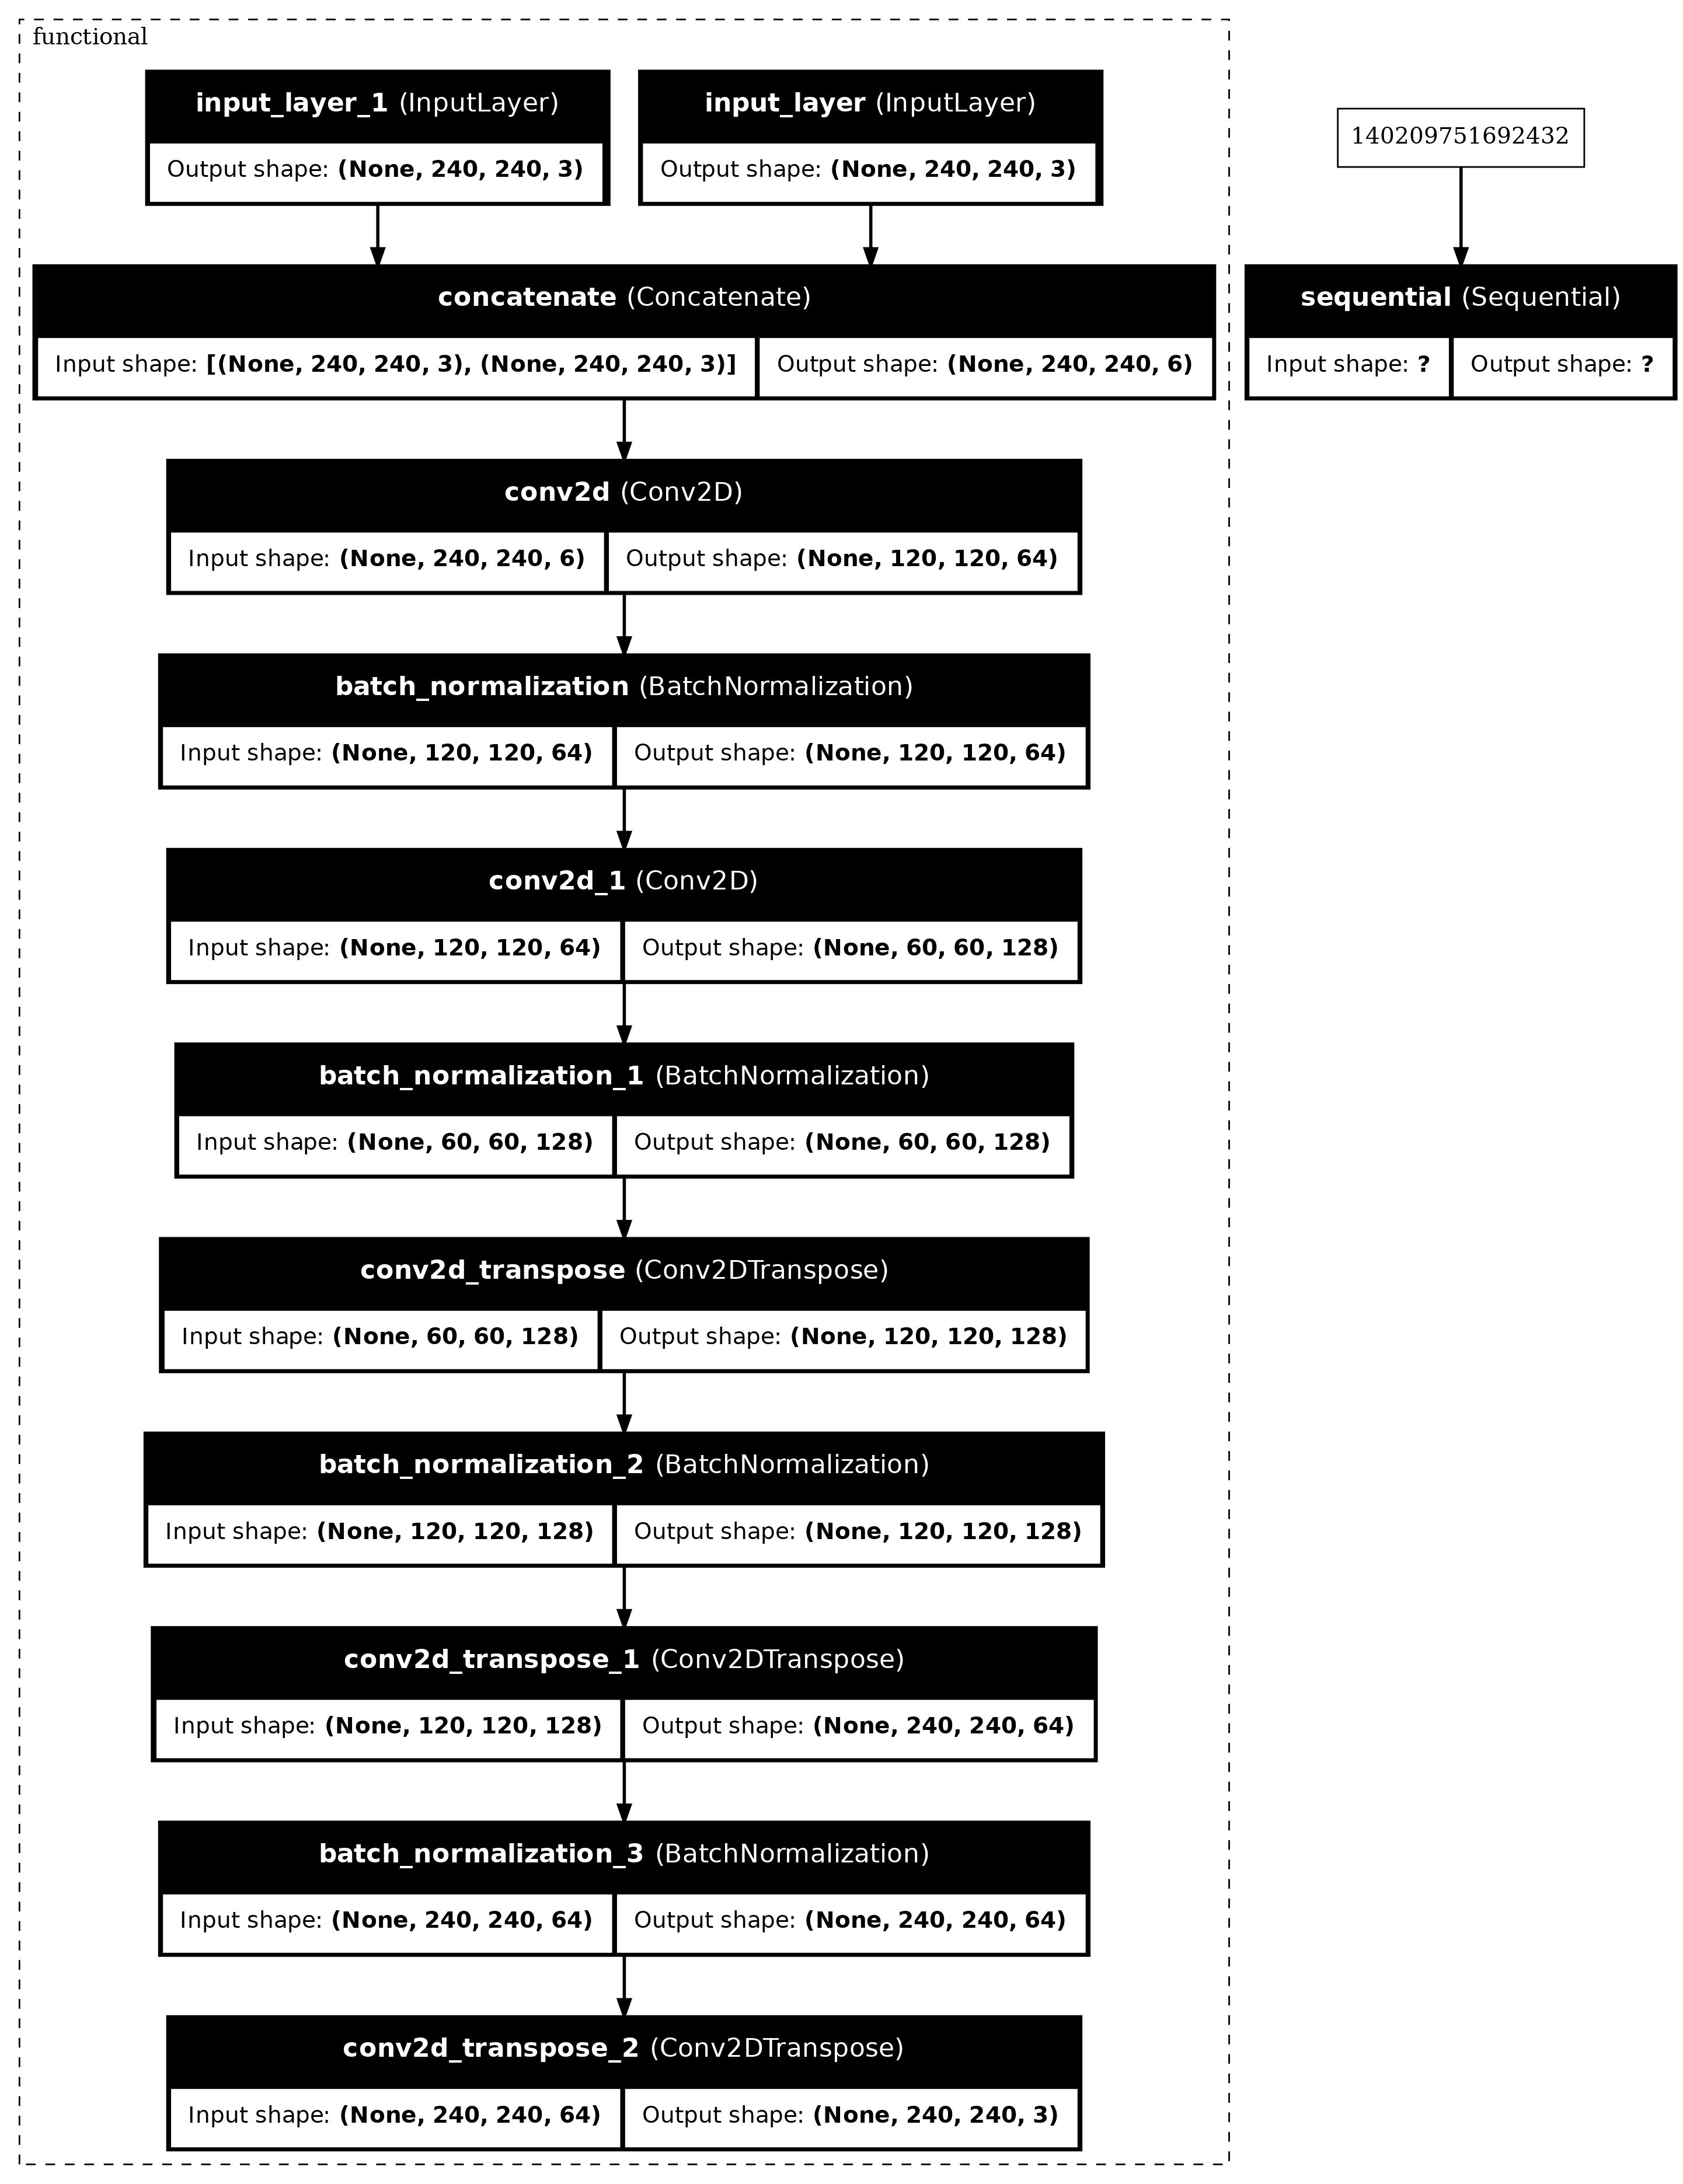

In [23]:
plot_model(GAN, to_file='model_structure.png', show_shapes=True, show_layer_names=True,expand_nested=True)

In [24]:
discriminator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 120, 120, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 460800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       460,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 670,593 (2.56 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 670,593 (2.56 MB)

In [ ]:

import matplotlib.pyplot as plt

def generate_and_save_images(model, epoch, object_images, background_images, num_examples=16):
    predictions = model.predict([object_images, background_images])
    fig = plt.figure(figsize=(4, 4))

    for i in range(num_examples):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] * 0.5 + 0.5))  # Rescale from [-1, 1] to [0, 1]
        plt.axis('off')

    plt.savefig(f'generated_image_at_epoch_{epoch:04d}.png')
    plt.show()

def train(dataset, epochs, batch_size):
    for epoch in range(epochs):
        for (object_images, background_images), real_images in dataset:
            # Generate fake images using the generator
            generated_images = generator.predict([object_images, background_images])
            real_labels = tf.ones((batch_size, 1))
            fake_labels = tf.zeros((batch_size, 1))
            discriminator.trainable = True
            discriminator.train_on_batch(real_images, real_labels)
            discriminator.train_on_batch(generated_images, fake_labels)
            discriminator.trainable = False
            g_loss = GAN.train_on_batch([object_images, background_images], real_labels)
            discriminator.trainable = True

        print(f'Epoch {epoch + 1}/{epochs}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}')
        
        # Generate and save images every few epochs
        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1, object_images[:16], background_images[:16])

# Run the training
train(dataset, EPOCHS, BATCH_SIZE)


Loading: "/tf/notebooks/targets/000000000025_target_0.png"
Loading: "/tf/notebooks/backgrounds/000000000025_background_0.png"
Loading: "/tf/notebooks/awsaf49/coco-2017-dataset/versions/2/coco2017/train2017/000000000025.jpg"
Loading: "/tf/notebooks/targets/000000000025_target_1.png"
Loading: "/tf/notebooks/backgrounds/000000000025_background_1.png"
Loading: "/tf/notebooks/awsaf49/coco-2017-dataset/versions/2/coco2017/train2017/000000000025.jpg"
Loading: "/tf/notebooks/targets/000000000030_target_0.png"
Loading: "/tf/notebooks/backgrounds/000000000030_background_0.png"
Loading: "/tf/notebooks/awsaf49/coco-2017-dataset/versions/2/coco2017/train2017/000000000030.jpg"
Loading: "/tf/notebooks/targets/000000000030_target_1.png"
Loading: "/tf/notebooks/backgrounds/000000000030_background_1.png"
Loading: "/tf/notebooks/awsaf49/coco-2017-dataset/versions/2/coco2017/train2017/000000000030.jpg"
Loading: "/tf/notebooks/targets/000000000030_target_2.png"
Loading: "/tf/notebooks/backgrounds/000000000

I0000 00:00:1732083199.077775    1262 service.cc:146] XLA service 0x7f83b80258e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732083199.077846    1262 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-11-20 06:13:19.101542: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


I0000 00:00:1732083202.552559    1262 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-11-20 06:13:26.834671: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion', 420 bytes spill stores, 436 bytes spill loads

2024-11-20 06:13:38.877518: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 192 bytes spill stores, 192 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_3', 76 bytes spill stores, 76 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_4', 184 bytes spill stores, 184 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_red

Loading: "/tf/notebooks/targets/000000000042_target_0.png"
Loading: "/tf/notebooks/backgrounds/000000000042_background_0.png"
Loading: "/tf/notebooks/awsaf49/coco-2017-dataset/versions/2/coco2017/train2017/000000000042.jpg"
Loading: "/tf/notebooks/targets/000000000071_target_0.png"
Loading: "/tf/notebooks/backgrounds/000000000071_background_0.png"
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Loading: "/tf/notebooks/awsaf49/coco-2017-dataset/versions/2/coco2017/train2017/000000000071.jpg"
Loading: "/tf/notebooks/targets/000000000072_target_0.png"
Loading: "/tf/notebooks/backgrounds/000000000072_background_0.png"
Loading: "/tf/notebooks/awsaf49/coco-2017-dataset/versions/2/coco2017/train2017/000000000072.jpg"
Loading: "/tf/notebooks/targets/000000000073_target_1.png"
Loading: "/tf/notebooks/backgrounds/000000000073_background_0.png"
Loading: "/tf/notebooks/awsaf49/coco-2017-dataset/versions/2/coco2017/train2017/000000000073.jpg"
Loading: "/tf/notebooks/targets/000000000078_target_0.png"
Loading

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [ ]:
print(tf.__version__)